# **YOUNGER - Age Estimator:  Preprocessing & Modeling**
---

###**Contents**




[**IV. PREPROCESSING**](#scrollTo=nAuKSR5HuQCy)

* 4.1 Introduction
* 4.2 Imports
* 4.3 Load Data
* 4.4 Transform Data
* 4.5 Train/Test Split
* 4.6 Data Augmentation

[**V. MODELING**](#scrollTo=QpXbL0ZoYSpN)

* 5.1 CNN Architecture
* 5.2 Transfer Learning
* 5.3 Train the Model
* 5.4 Model Performance
* 5.5 Performance Visualization
* 5.6 Unseen Data Test

[**VI. SUMMARY**](#scrollTo=fRhrsD9SjrO7)


[**VII. REFERENCES**](#scrollTo=tD6Lsmxlh3s8)

[**VIII. APPENDIX**](#scrollTo=UhDT3ZLzzWxs)

---

# **IV. PREPROCESSING**

##**4.1 Introduction**

Previously, to create an age-predictor, we have completed a notebook to import data and explore its attributes: [Data Wrangling & Exploratory Data Analysis](https://github.com/premonish/YOUNGER/blob/main/notebooks/YOUNGER_Age_Estimator_WRANGLING_EDA_v2.ipynb). We took a close look at the metadata and plotted some histograms of the variable distributions. We transformed the data to extract the age of the primary face in each image from their date-of-birth and the date the photo was taken. We focused on extracting a long array of vectors of the pixel information per photo. We finished the previous phase by creating 2 arrays: 'matrix_x' with each row containing the (150,000+ pixel/image) data from each image in the dataset, and 'vector_y' containing the corresponding 'age' labels for the images. 

In this notebook, we will focus on Preprocessing & Modeling. In particular, we will use a Convolutional Neural Network, which is industry standard for Machine Learning image classification tasks due to its unmatched performance.  


---



**Class Balance Note:** 
We decided to focus on predicting only the well represented age classes [8-80]. The dataset did not contain enough examples of other ages. Since the dataset had many examples for other ages, we decided to downsample to balance the classes.


**Historical Context** 
>
> Image classification has been around for decades, however the field has been rapidly maturing in the last decade.  Since 2010, [ImageNet](https://https://en.wikipedia.org/wiki/ImageNet) Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition where teams attempt to categorize thousands of images into 1,000 classes. In 2012, 'AlexNet' won the competition by a landslide and this is considered a pivotal moment in the history of deep learning, enabled by ingenious data scientists, a massive labeled dataset, and GPUs for training.




**PREPROCESSING** will be focused on three main sections.

1. Create Dummy Variables for categorical variables. (One-Hot Encoding)
2. Standardize the magnitude of numeric features using a scaler. (Scale 0-1)
3. Split data into testing and training datasets.
---

## **4.2 Imports**

In [1]:
# !pip install tensorflow

In [2]:
# Create a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt
# Available here: https://github.com/premonish/YOUNGER/blob/main/requirements2.txt

In [3]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# deep-learning imports
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

In [4]:
# mount GDrive where the dataset is stored for Colab environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **4.3 Load Data**
Let's load the compressed numpy arrays from disk, extract data, and check the number of rows in our dataset.

In [5]:
%%time
from numpy import asarray, savez_compressed, load
# load dict of arrays
images = np.load('/content/drive/MyDrive/YOUNGER/data5.npz', allow_pickle=True)
matrix_x = images.f.arr_0
X = matrix_x
X.shape

CPU times: user 12.6 s, sys: 2.1 s, total: 14.7 s
Wall time: 19 s


In [6]:
# load the ages array 'vector_y'
ages = np.load('/content/drive/MyDrive/YOUNGER/data6.npz', allow_pickle=True)
vector_y = ages.f.arr_0
y = vector_y
y.shape

(5037,)

In [7]:
# check output matrix_x & vector_y shapes
# both matrix_x and vector_y are arrays of the same length 
assert vector_y.shape == matrix_x.shape

**NOTE:** I've run many tests to see how many images to include without overwhelming Google Colab's RAM. 

I have already upgraded to Colab Pro for this project and have been reaching the RAM limits

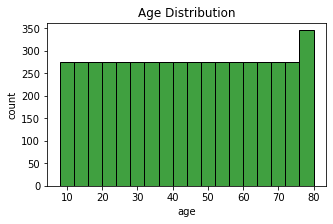

In [8]:
# Plot Age Distribution represented in the dataset
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.histplot(y, color='green')
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

**^ Notice the balanced classes of the input data achieved in preprocessing.**
 
We decided to focus on predicting only the well represented age classes [8-80]. The dataset did not contain enough examples of other ages. Since the dataset had many examples for other ages, we decided to downsample to balance the classes.

---

## **4.4 Transform Data**

**One-Hot Encoding**

We need to encode the 'ages' label as categorical (binary) representations to prepare for machine learning. 
The Keras API provides a 'to_categorical()' method that can be used to one-hot encode integer data. 

In [9]:
# classes = 101   # ages 0 to 100   # We didn't have enough training examples to predict 101 classes
classes = 73      # ages 8 to 80 (inclusive - inclusive)
target = y-8      # prepare for zero-indexed encoding - must add for prediction

# "Converts a class vector (integers) to binary class matrix." 
target_classes = keras.utils.to_categorical(target, classes) 

**Reshaping the Data**

We must reshape the data into the standard input array shape of a 'rank 4 tensor' to prepare for the Tensorflow CNN.

(b, w, h, c) : (batch, width, height, channels)

In [10]:
features = []
for i in range(0, len(X)):
    features.append(X[i])
features = np.array(features)
features = features.reshape(len(X),224,224,3)
features.shape

(5037, 224, 224, 3)

**Scale the Data**

Each of the pixel values range from 0-255. Let's scale the values to from 0-1 by dividing each value by 255. Interestingly, we are actually performing this operation virtually instantly 150,528 times per image (times the number of images).

In [11]:
features /= 255        # scale down pixel values to range [0, 1]
print("The maximum value in our dataset is:", features.max())

The maximum value in our dataset is: 1.0




---



## **4.5 Train/Test Split**
We will divide the dataset randomly into training data and test data (80/20). We will later perform data augmentation on only the training set to help balance the classes of ages in the dataset.

In [12]:
# train/ test split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30, random_state=42, stratify=target_classes)

In [13]:
print("X_train shape =" ,train_x.shape) 
print("X_test  shape ="  ,test_x.shape)
print('- - - - - - - - - - - - - - - - - -')
print("y_train shape =" ,train_y.shape)
print("y_test  shape ="  ,test_y.shape)

X_train shape = (3525, 224, 224, 3)
X_test  shape = (1512, 224, 224, 3)
- - - - - - - - - - - - - - - - - -
y_train shape = (3525, 73)
y_test  shape = (1512, 73)


Now that we have one-hot encoded the target classes, shaped the input data into tensor-like shapes, scaled the data to 0-1, and split the dataset into training and test subsets, we are ready to move onto modeling.

## **4.5 Data Augmentation**
We will apply some data tranformations to add variation to the training set during when feeding the data into the CNN. We will use random horizontal flipping, random rotations and slight random zooms to increase the diversity of the training data with the intention to reduce overfitting.

In [14]:
# data augmentation using TensorFlow & Keras to be applied at the start of the CNN
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)



---



# **V. MODELING**

**MODELING** will focus on the following four phases.
1. Train the models on the dataset (fit)
2. Review model performance metrics
3. Iterate over other models
4. Identify the final model  


---



## **5.1 CNN Architecture**

I'll start by using an established architecture titled "[VGG-Face](https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf)" effective for facial recognition and building custom layers on top. This model was created by the Visual Geometry Group, at the University of Oxford to recognize 2,622 celebrities. Facial recognition is a more complex task than age prediction, yet the features extracted from many of the early layers of this model can be useful to our problem.

"These models can be used for non-commercial research purposes under [Creative Commons Attribution License](https://creativecommons.org/licenses/by-nc/4.0/)."

[VGGFace Github](https://github.com/rcmalli/keras-vggface)


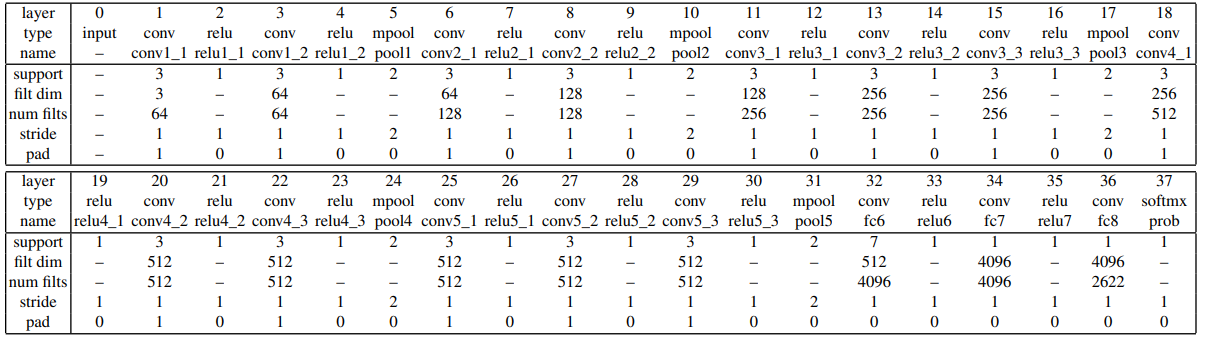

**^ VGG-Face Architecture** The first 8 blocks are convolutional. The last 3 blocks are Fully Connected (fc). All convolution layers are followed by a ReLU (recitified linear unit) activation later. A softmax layer predicts probabilities of the labels.

In [15]:
#VGG-Face model
model = Sequential(data_augmentation)                    # apply data augmentation
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))



---



## **5.2 Transfer Learning**

Transfer learning allows us to use weights that have already been trained on a massive dataset (2.6M images in this case). For similar tasks, we can simply freeze the weights for many of the early layers. However, the later layers in the model will need to trained and tuned for our specific task.

**Trained weights source:** 
https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf

In [16]:
# load the pre-trained weights to take advantage of transfer learning
model.load_weights('/content/drive/MyDrive/YOUNGER/vgg_face_weights.h5')

**To take advantage of transfer learning, we will freeze layers with trained weights. We will custom tune the last four layers for our age predictor based on our training set.**

In [17]:
# freeze layers to use transfer learning effectively
for layer in model.layers[:-7]:
  layer.trainable = False

# add custom layers to predict on unique dataset and problem 
base_model_output = Sequential()
base_model_output = Convolution2D(73, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [18]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

**Compile Model**

Categorical crossentropy is an appropriate loss function for multi-class classification problems. 

We will use an 'Adam' optimizer with a learning rate of 0.0007.

In [19]:
# Stochastic Gradient Descent = sgd
# compile the model
# sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=.9, nesterov=True)

opt = keras.optimizers.Adam(learning_rate=0.0007,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name="Adam"
)

# 'categorical_crossentropy' is an appropriate loss function for a multi-class classification problem such as ours
age_model.compile(loss='categorical_crossentropy'
                  , optimizer = opt
                  # , optimizer = sgd
                  , metrics=['accuracy']
                 )

**Model Checkpoint**

Validation Loss is our key performance metric. We create a checkpointer which automatically saves the best model based on improved 'val_loss' performance. We can later use the best pre-trained model to measure the performance of the model on unseen data.

In [20]:
# create checkpoint which saves the best model based on loss on the validation data 
# if the validation loss decreases, the model will be saved as a checkpoint
checkpointer = ModelCheckpoint(
    # filepath='/content/classification_age_model.hdf5'
    filepath='/content/drive/MyDrive/YOUNGER/classification_age_model_6.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'min'
    # , mode = 'auto'
)

**Early Stopping**

Early Stopping will notice when the validation loss is not improving  and it will stop the training to prevent overfitting.

In [21]:
# enable Early Stopping 
from tensorflow.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

**Tensorboard**

Tensorboard allows us to experiment, visualizing changes in model details (hyperparameters) and perfomance metrics.

In [22]:
#tensorboard
%load_ext tensorboard
import datetime

In [23]:
# instantiate TensorBoard and define callback variable
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Save Performance Metrics**

Kera's 'History' callback allows us to track performance metrics which we can later visualize.

In [24]:
# record model performance
from keras.callbacks import History 
history = History()

In [25]:
# Clear any logs from previous runs - TensorBoard
! rm -rf ./logs/



---



##**5.3 Train the Model**

Training the model is where the magic happens. We will train our model for a given number of epochs with a given batchsize. We have tried many iterations with various batchsizes and various numbers of epochs to reach allow proper training while avoiding overfitting. Our primary performance metric is validation loss. As the model progresses through epochs, we want the validation loss to decrease at a steady pace.

We will save our best model. In the future, we can simply use the saved model to predict on new data. 

In [26]:
# set batch size and # of epochs
# fit the model on training set & validate on the test set
epochs = 200           # original = 250
batch_size = 128       # original = 256

enableFit = True

if enableFit:
    for i in range(epochs):
        print("epoch ",i)
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train],
            epochs=1,
            validation_data=(test_x, test_y),
            callbacks=[tensorboard_callback, checkpointer, callback, history])
        
    #restore the best weights
    from keras.models import load_model
    age_model = load_model('/content/drive/MyDrive/YOUNGER/classification_age_model_6.hdf5')
    age_model.save_weights('/content/drive/MyDrive/YOUNGER/age_model_weights_6.h5')
        
else:
    # pre-trained weights for age prediction
    age_model.load_weights("/content/drive/MyDrive/YOUNGER/age_model_weights_6.h5")

epoch  0
4/4 [==============================] - 25s 2s/step - loss: 4.2897 - accuracy: 0.0083 - val_loss: 4.2883 - val_accuracy: 0.0159

Epoch 00001: val_loss improved from inf to 4.28832, saving model to /content/drive/MyDrive/YOUNGER/classification_age_model_6.hdf5
epoch  1
4/4 [==============================] - 4s 1s/step - loss: 4.3106 - accuracy: 0.0078 - val_loss: 4.3164 - val_accuracy: 0.0179

Epoch 00001: val_loss did not improve from 4.28832
epoch  2
4/4 [==============================] - 4s 1s/step - loss: 4.3372 - accuracy: 0.0312 - val_loss: 4.3179 - val_accuracy: 0.0231

Epoch 00001: val_loss did not improve from 4.28832
epoch  3
4/4 [==============================] - 4s 1s/step - loss: 4.3024 - accuracy: 0.0234 - val_loss: 4.3422 - val_accuracy: 0.0139

Epoch 00001: val_loss did not improve from 4.28832
epoch  4
4/4 [==============================] - 4s 1s/step - loss: 4.3266 - accuracy: 0.0312 - val_loss: 4.3280 - val_accuracy: 0.0132

Epoch 00001: val_loss did not impro



---



##**5.4 Model Performance**

We will assess the performance of the model by plotting the **validation set loss versus the training set loss**. If the performance of the training set improves too fast and diverges from the validation set, this is a sign of overfitting. Our objective is to prevent overfitting, thus making the model more robust to unseen data. 

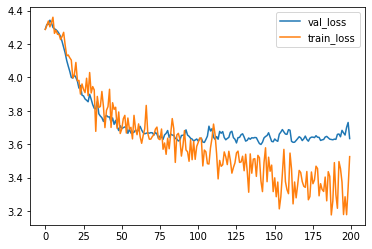

In [27]:
# plot training loss vs. validation loss over epochs
val_loss_change = []; loss_change = []
for i in range(0, epochs):
    val_loss_change.append(history.history['val_loss'][i])
    loss_change.append(history.history['loss'][i])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

We will also assess the performance of the model by plotting the **validation set accuracy versus the training set accuracy**.

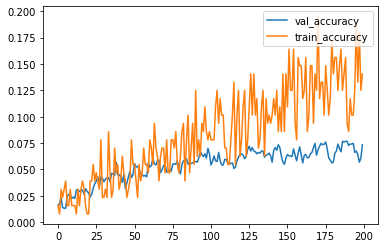

In [28]:
# plot training loss vs. validation loss over epochs
val_accuracy_change = []; accuracy_change = []
for i in range(0, epochs):
    val_accuracy_change.append(history.history['val_accuracy'][i])
    accuracy_change.append(history.history['accuracy'][i])

plt.plot(val_accuracy_change, label='val_accuracy')
plt.plot(accuracy_change, label='train_accuracy')
plt.legend(loc='upper right')
plt.show()

**Check the training set loss and accuracy.**

In [29]:
# loss and accuracy on training set
train_eval = age_model.evaluate(train_x, train_y, verbose=1 , return_dict=True)
train_eval

111/111 [==============================] - 8s 67ms/step - loss: 3.1395 - accuracy: 0.1881


{'accuracy': 0.18808510899543762, 'loss': 3.1394870281219482}

**Check the test set loss and accuracy.**

In [30]:
# loss and accuracy on test set
test_eval = age_model.evaluate(test_x, test_y, verbose=1 , return_dict=True)
test_eval

48/48 [==============================] - 3s 61ms/step - loss: 3.5990 - accuracy: 0.0681


{'accuracy': 0.06812169402837753, 'loss': 3.5989954471588135}

**Predictions on the test set.**

In [31]:
predictions = age_model.predict(test_x)

**The array of predictions need to be decoded into predicted ages.**

In [32]:
output_indexes = np.array([i for i in range(8, 81)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1) 

**Let's take a look at the maximum, minimum and mean age predictions to ensure that our distribution of values is what we expected.**

In [33]:
prediction_list = []
for i in range(73):
  prediction_list.append((np.argmax(predictions[i] * output_indexes[i])+8))

print("Minumum Predicted Age:",min(prediction_list))
print("Maximum Predicted Age:",max(prediction_list))
print("Average Predicted Age:",np.mean(prediction_list))

Minumum Predicted Age: 8
Maximum Predicted Age: 80
Average Predicted Age: 45.3013698630137


**Mean Absolute Error**

Compute the Mean Absolute Error (MAE) to see how far the predicted ages are from the actual ages on average. MAE is the primary performance metric of our project.

In [34]:
# compute mae
mae_sum = 0
errors = []
n = apparent_predictions.shape[0]
prediction_list = []
for i in range(n):
    prediction = apparent_predictions[i]
    actual = np.argmax(test_y[i]) + 8
    mae_sum += abs(actual  - prediction)

    prediction_list.append(int(apparent_predictions[i])) # create a prediction list to plot
    errors.append((np.argmax(test_y[i]) + 8) - apparent_predictions[i])

mae = mae_sum / n
print("mae: ",mae)
print("instances: ", n)

mae:  7.65525963119018
instances:  1512


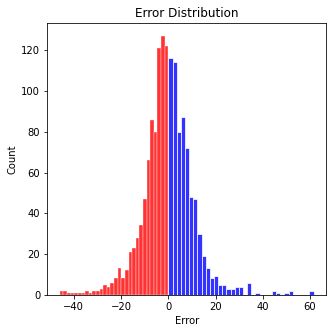

In [35]:
# visualize the actual vs predicted age error distribution 
positive_errors = [i for i in errors if i > 0]
negative_errors = [i for i in errors if i < 0]

fig, ax = plt.subplots(figsize=(5,5))
sns.set_theme(style="darkgrid")
sns.histplot(positive_errors, color='blue', alpha=.8)
sns.histplot(negative_errors, color='red', alpha=.8)
plt.title('Error Distribution')
plt.xlabel('Error');

In [36]:
# Let's assume a Gaussian distribution of the errors
errors_mean = np.mean(errors)
errors_std = np.std(errors)
positive_std   = np.mean(errors) + np.std(errors) 
positive_std2  = np.mean(errors) + np.std(errors)*2
positive_std3  = np.mean(errors) + np.std(errors)*3
negative_std   = np.mean(errors) - np.std(errors)
negative_std2  = np.mean(errors) - np.std(errors)*2
negative_std3  = np.mean(errors) - np.std(errors)*3

print("Errors: Mean:",errors_mean)
print("Errors: Standard Deviation:",errors_std)
print("Errors: 1 Positive Standard Deviation: ",positive_std)
print("Errors: 2 Positive Standard Deviation: ",positive_std2)
print("Errors: 3 Positive Standard Deviation: ",positive_std3)
print("Errors: 1 Negative Standard Deviation:",negative_std)
print("Errors: 2 Negative Standard Deviation:",negative_std2)
print("Errors: 3 Negative Standard Deviation:",negative_std3)

Errors: Mean: -0.5127970834061821
Errors: Standard Deviation: 10.780623882597904
Errors: 1 Positive Standard Deviation:  10.267826799191722
Errors: 2 Positive Standard Deviation:  21.048450681789628
Errors: 3 Positive Standard Deviation:  31.82907456438753
Errors: 1 Negative Standard Deviation: -11.293420966004087
Errors: 2 Negative Standard Deviation: -22.07404484860199
Errors: 3 Negative Standard Deviation: -32.854668731199894


In [37]:
# 68, 95, 99.7 = "three-sigma rule" AKA empirical rule for normal distributions
print("~ 68%   prediction errors from",round(negative_std,2),'to',round(positive_std,2))
print("~ 95%   prediction errors from",round(negative_std2,2),'to',round(positive_std2,2))
print("~ 99.7% prediction errors from",round(negative_std3,2),'to',round(positive_std3,2))

~ 68%   prediction errors from -11.29 to 10.27
~ 95%   prediction errors from -22.07 to 21.05
~ 99.7% prediction errors from -32.85 to 31.83


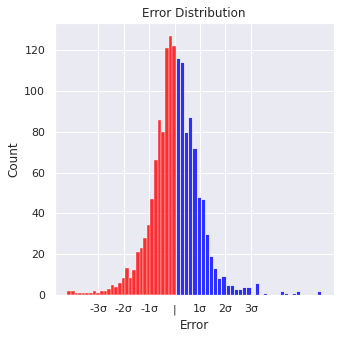

In [38]:
# # visualize the actual vs predicted age error distribution with standard deviations as x ticks

fig, ax = plt.subplots(figsize=(5,5))
sns.set_theme(style="darkgrid")
sns.histplot(positive_errors, color='blue', alpha=.8)
sns.histplot(negative_errors, color='red', alpha=.8)
plt.title('Error Distribution')
plt.xlabel('Error')
ticky = [negative_std3, negative_std2, negative_std, errors_mean, positive_std, positive_std2, positive_std3]
tacky = ['-3σ','-2σ','-1σ','|','1σ','2σ','3σ']
plt.xticks(ticky, tacky);

**Mean Absolute Percentage Error**

Compute the Mean Absolute Percentage Error (MAPE) to see how far the predicted ages are from the actual ages on average as a percentage.

In [39]:
# create list 'test_y_age'  of the actual age labels
test_y_age = np.argmax(test_y, axis=1)

# ADD 8 to the test_y labels. 8 was subtracted for one-hot categorical encoding
test_y_age = test_y_age + 8

In [40]:
# calculate MAPE
mape_sum = 0
n = apparent_predictions.shape[0]
for i in range(n): 
  mape_sum += (abs((test_y_age[i]) - (apparent_predictions[i]))/(test_y_age[i]))
mape = (mape_sum/n) 

print(mape)
print('MAPE:',(round(mape*100,2)),"%")

0.26266383270860244
MAPE: 26.27 %




---



##**5.5 Performance Visualization**

Let's create data visualizations to compare the predicted ages with the actual ages. We will create a few to survey which data visualization is the most useful for analysis.  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


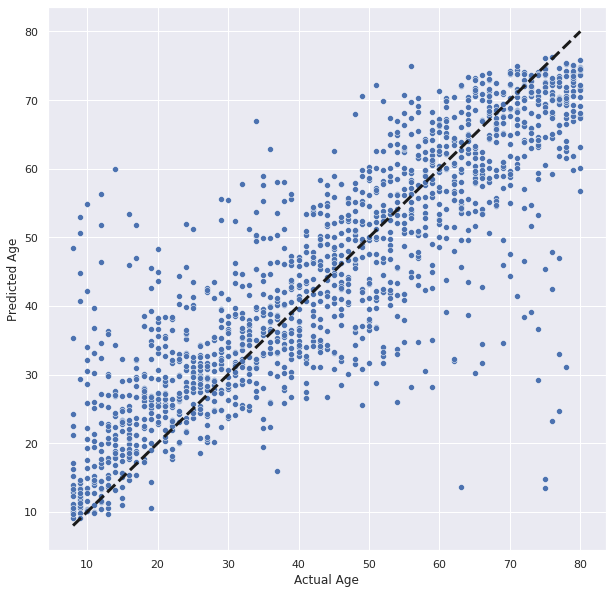

In [41]:
# plot a scatterplot with a 'perfect prediction' line
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(test_y_age, apparent_predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age');

**Observation:** Above, we can see the 'perfect prediction' dotted line and get a general sense of the error pattern in the system. Generally, there is a positive correlation between actual age and predicted age. We can also see some predictions far from the ideal line.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


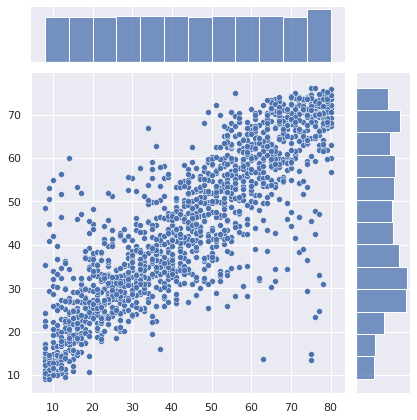

In [42]:
# jointplot - scatterplot with histogram
sns.jointplot(test_y_age, apparent_predictions)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age');

**Correlation**

Check Pearson Correlation Coefficient between predicted ages and actual ages.

In [43]:
# corr(test_y_age, apparent_predictions)
np.corrcoef(test_y_age, apparent_predictions)

array([[1.        , 0.85894874],
       [0.85894874, 1.        ]])

**Confusion Matrix**

We will create and plot a Confusion Matrix to visualize prediction accuracy in a grid.

In [44]:
# confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools
sns.set_theme(style='dark')
# prediction_list = np.array(prediction_list) + 8
conf_mat1 = confusion_matrix(test_y_age, prediction_list)

In [45]:
# plot the confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, cmap=cmap, interpolation='nearest')
    plt.title(title, fontsize=22)
    plt.colorbar()
    a_list = list(range(73))
    b_list = [8,'',10,'','','','',15,'','','','',20,'','','','',25,'','','','',30,'','','','',35,'','','','',40,'','','','',\
                   45,'','','','',50,'','','','',55,'','','','',60,'','','','',65,'','','','',70,'','','','',75 ,'','','','',80]
    plt.xticks(a_list, b_list, fontsize=12)
    plt.yticks(a_list, b_list, fontsize=12)

    plt.tight_layout()
    plt.ylabel('Predicted Age', fontsize=18)
    plt.xlabel('Actual Age', fontsize=18)
    plt.savefig('/content/drive/MyDrive/YOUNGER/conf_mat1.png');

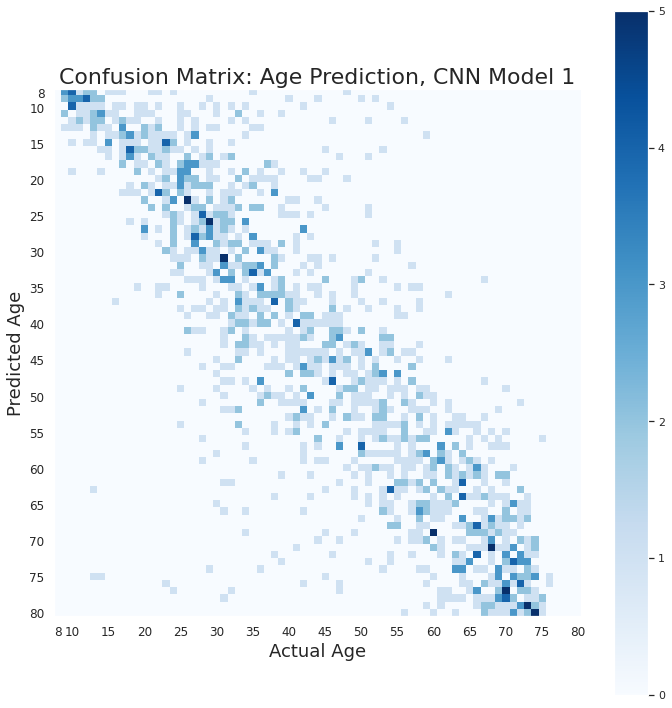

In [46]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_mat1, list(range(73)), normalize=False,
                      title="Confusion Matrix: Age Prediction, CNN Model 1")
plt.show()

**Observation:**
Again, we can see the correlation trend forming a linear shape. Perfect predictions would form a dark blue line from top-left to bottom-right. The predictions are far from perfect. 

**Best Predictions, Decent Predicitions, Poor Predictions**

Clearly, the predictor predicts better at certain ages than other ages. 

The predictor is most accurate at ages: 8, 9, 11-14, 16 and 73.


The predictor is somewhat accurate at ages: 14, 17, 25, 30, 31, 34, 36, 39, 40, 42, 45, 46, 49, 53, 56, 58, 63, 67, 70, 72, 73. 

The predictor predicts poorly at ages: 35, 43, 48, and 65.



---



##**5.6 Unseen Data Test**

We will create a sequence to predict the ages of new images loaded through Google Drive and also images from on the Internet. 

We can imagine this being the "app" where a user inputs their photo and the app returns an age prediction. This is the practical application of the predictor. 

**There are 2 predictions.** Prediction 1 is the highest probability prediction and Prediction 2 is the average of the top 5 highest probability predictions.

"Actual Ages" are based on the date the images were captured verified by cross-checking Getty Images for the celebrities.

In [47]:
# image preprocessing
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [48]:
# predictor function using the model created above
from keras.preprocessing import image
sns.set_theme(style='dark')

def image_age(photo):
  prediction2 = age_model.predict(loadImage(photo))
  img = image.load_img(photo)#, target_size=(224, 224))
  plt.xticks([], []), ax.set_xticks([]), plt.yticks([], []), ax.set_yticks([]) # clear x & y ticks
  plt.imshow(img)   # display image
  plt.show()
  
  # print("Predicted Age: ", (np.argmax(prediction))+8)
  apparent_age = np.round(np.sum(prediction2 * output_indexes, axis=1))
  print(" Predicted Age: ", int(apparent_age[0]))
  print(" Average Top 5: ",round(np.mean(np.argsort(prediction2[0])[-5:])+8))
  print(" ------------------")
  

In [49]:
# visualize probabilites of each age class
def viz_prob(pic):
  prediction_1 = age_model.predict(loadImage(pic))
  y_pos = np.arange(73)+8
  plt.bar(y_pos, prediction_1[0], align='center', alpha=0.8)
  plt.ylabel('predicted probability')
  plt.xlabel('age')
  plt.title('Age Prediction Probabilities')
  plt.show()

**Load New Image, Predict Age, Visualize Probabilites**

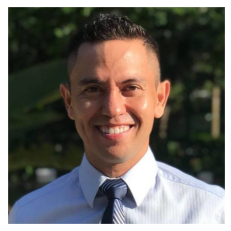

 Predicted Age:  38
 Average Top 5:  36
 ------------------
 Actual Age:     35


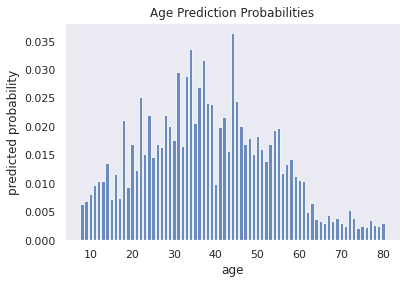

In [66]:
# insert image (of me) from Google Drive by path
picture1 = "/content/drive/MyDrive/YOUNGER/prem_linked.jpg"
image_age(picture1)
print(' Actual Age:     35')
viz_prob(picture1)

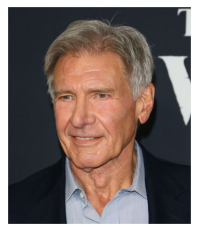

 Predicted Age:  70
 Average Top 5:  73
 ------------------
 Actual Age:     70


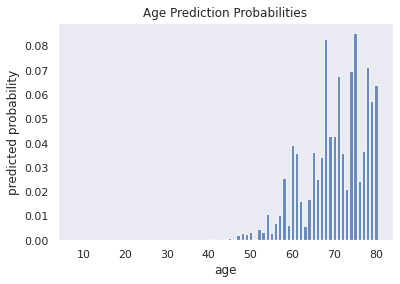

In [51]:
picture2 = '/content/drive/MyDrive/YOUNGER/harrison_ford_70.jpg'
image_age(picture2)
print(' Actual Age:     70')
viz_prob(picture2)

In [52]:
# create a web image upload & predict sequence
from PIL import Image
import requests

def web_age(url):  
  web_photo = Image.open(requests.get(url, stream=True).raw).save("web_photo.jpg")
  picture1 = "/content/web_photo.jpg"
  image_age(picture1)
  # viz_prob(picture1)

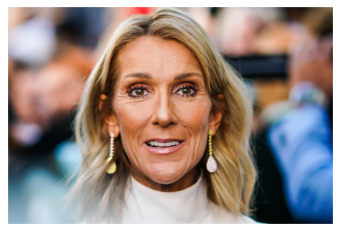

 Predicted Age:  63
 Average Top 5:  65
 ------------------
 Actual Age:     52


In [53]:
url = "https://media.allure.com/photos/5e8359941cb813000841fb8b/3:2/w_3000,h_2000,c_limit/celine%20dion.jpg"
web_age(url)
print(' Actual Age:     52')

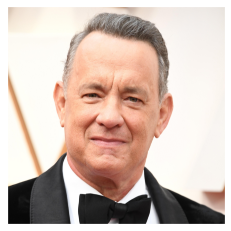

 Predicted Age:  62
 Average Top 5:  60
 ------------------
 Actual Age:     63


In [54]:
url = 'https://assets.vogue.com/photos/5e6f950f5530ac0009b932fb/1:1/w_3538,h_3538,c_limit/GettyImages-1205201930.jpg'
web_age(url)
print(' Actual Age:     63')

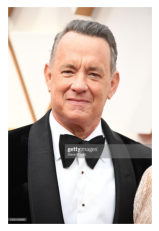

 Predicted Age:  65
 Average Top 5:  71
 ------------------
 Actual Age:     63


In [55]:
url = 'https://media.gettyimages.com/photos/tom-hanks-attends-the-92nd-annual-academy-awards-at-hollywood-and-on-picture-id1205142068?s=2048x2048'
web_age(url)
print(' Actual Age:     63')

The prediction is better for the image that is tightly cropped. The predictor was trained on images with a specific 40% margin, tightly cropped. We can expect that the predictor would perform better on images similar to the training set. 

One possible method to improve performance on unseen data is to have the system pre-process new images by cropping them with the correct margin and image size.

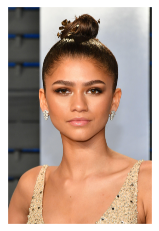

 Predicted Age:  22
 Average Top 5:  22
 ------------------
 Actual Age:     20


In [56]:
url = 'https://static.wikia.nocookie.net/euphoria-hbo/images/5/5c/Zendaya.jpg/revision/latest?cb=20190601162350'
web_age(url)
print(' Actual Age:     20')

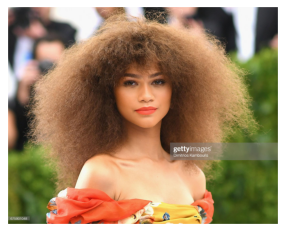

 Predicted Age:  39
 Average Top 5:  14
 ------------------
 Actual Age:     20


In [57]:
url = 'https://media.gettyimages.com/photos/zendaya-attends-the-rei-kawakubocomme-des-garcons-art-of-the-costume-picture-id675901048?s=2048x2048'
web_age(url)
print(' Actual Age:     20')

Above, the same person, Zendaya, at the same age is predicted well, and then predicted poorly. Perhaps the unique hair feature is being read as wrinkles. Perhaps frizzy hair is associated with older people.

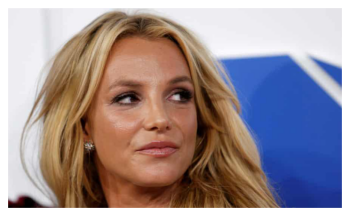

 Predicted Age:  43
 Average Top 5:  43
 ------------------
 Actual Age:     34


In [58]:
url = 'https://i.guim.co.uk/img/media/7f2b972fa41cd4d26a3620cea335aad33cde6c32/0_127_3500_2101/master/3500.jpg?width=445&quality=45&auto=format&fit=max&dpr=2&s=02571424bc9abc13340589ef47eb7b0b'
web_age(url)
print(' Actual Age:     34')

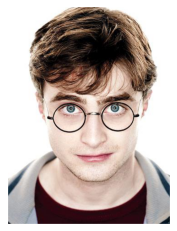

 Predicted Age:  27
 Average Top 5:  17
 ------------------
 Actual Age:     20


In [59]:
url = 'https://static.wikia.nocookie.net/harrypotter/images/9/97/Harry_Potter.jpg/revision/latest?cb=20140603201724'
web_age(url)
print(' Actual Age:     20')

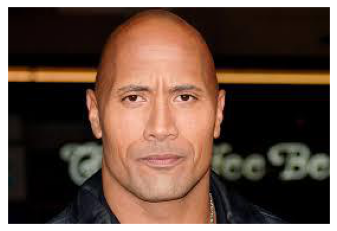

 Predicted Age:  48
 Average Top 5:  49
 ------------------
 Actual Age:     48


In [60]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRed4B_N95FjRE0a-2sn3OEXAjc0SkMkWeJTQ&usqp=CAU'
web_age(url)
print(' Actual Age:     48')



---



# **VI. SUMMARY**



Well, that was a lot. Let's take a look at what this notebook covers. 

**Preprocessing**

During preprocessing, we loaded and prepared the data for machine learning by one-hot encoding the target classes. We scaled the pixel values from 0-255 to 0-1. We also split the data into training and testing subsets.

**Modeling**

Onward to modeling, we used a proven model arcitecture with pretrained weights for the first layers to expedite our learning. By using transfer learning we were able to use the existing model weights that have been previously trained on a massive 2.6 million image dataset. We froze the early layers and focuses on training the later layers in the model. Next we trained the model, observed results of the training, and reset the batchsize and the number of epochs to achieve a reasonable learning rate without overfitting.

**Metrics**

Our primary model performance metric is validation loss. We created our model to train to minimize validation loss and save the best weights progressively. We eventually got down to a reasonable validation loss for this project.

Our primary overall metric is Mean Absolute Error (MAE). We want to minimize how far our predicted are from the actual ages. So far our MAE is still far from ideal. Training on a lot more data will help.

**Visualizations**

We created a confusion matrix, a scatterplot and a jointplot to get a sense of how well the model is predicting. Overall, the general trend is positive but there is room for improvement.

**Unseen Data**

We created a small program to predict the ages for new images from Google Drive and from the Internet. The results were encouraging.



---



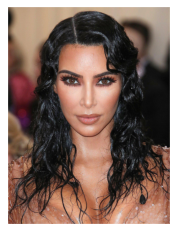

 Predicted Age:  34
 Average Top 5:  26
 ------------------
 Actual Age:     37


In [67]:
# one for the road
url = 'https://imagesvc.meredithcorp.io/v3/mm/image?q=85&c=sc&poi=face&w=1200&h=1600&url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F20%2F2019%2F05%2Fkim-beauty.jpg'
web_age(url)
print(' Actual Age:     37')



---



# **VII. REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles
5. https://github.com/yu4u/age-gender-estimation
6. https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf
7. https://link.springer.com/chapter/10.1007/978-3-319-10593-2_47


---

# **VIII. APPENDIX**


**Model Summary**

[VGG-Face Model](https://https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf) was the basis for our model. We used the VGG-Face structure and trained on the last 4 custom layers.

In [62]:
age_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_input (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0     



---



**TensorBoard**
TensorBoard visualization for experimentation.

In [68]:
# # !kill 380
# %tensorboard --logdir logs/fit

In [70]:
# !tensorboard dev upload \
#   --logdir logs/fit \
#   --name "My latest experiment" \
#   --description "Simple comparison of hyperparameters" \
#   --one_shot

[TensorBoard for this Notebook](hhttps://tensorboard.dev/experiment/VsomWP3YQsWuOFglmW7dnw/#graphs&run=20210518-022919%2Ftrain)



---

